In [1]:
# experiment to compare
from contrib.experiments import *
exp = HR_90

In [2]:
import xarray as xr

from contrib import *
from contrib.plotting import plotFringe, plotGMT
from contrib.HR import ProjHR

from mintpy.tsview import timeseriesViewer
from mintpy.view import viewer
from contrib.plotting.plotGMT import PlotHR, prep_GPS_HR

from VLM import bbMP

%pdb off
%matplotlib inline

print ('\nData is at:', os.getenv('dataroot'))
print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now().date())

Automatic pdb calling has been turned OFF

Data is at: /u/leffe-data2/buzzanga/data/
(FRInGE)  2022-07-03


In [3]:
Exp = ExpBase(exp)
os.chdir(Exp.path_wd)

print ('PWD:', os.getcwd())

if mpl.get_backend() == 'nbAgg':
    fs, ls = (8, 8), 8
else:
    fs, ls = (40, 40), 30

PWD: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR2


## Setup HR

In [4]:
def make_HR2020_results(method='simple'):
    """ Make the netcdfs of the 'new' HR results intended to match paper """
    ProjHR.ProjHR(path_vup_mp_orig, path_ifgram_mask, corr='SBAS')(method, radius=500) # stitch, simple
    
    cmds = [
    f'gdal_translate {path_rate_orig0} {path_rate_orig} -of netCDF',
    f'gdal_translate {path_unc_orig0} {path_unc_orig} -of netCDF',
     
    f'save_gdal.py {path_stitch_mp} -d velocity -o {path_rate_orig1} --of netCDF',
    f'save_gdal.py {path_stitch_mp} -d velocityStd -o {path_unc_orig1} --of netCDF',  
    f'save_gdal.py {path_ifgram_mask} -o {path_ifgram_mask_nc} --of netCDF',  
       ]
    for cmd in cmds:
        print (cmd)
        !{cmd}
    return

In [5]:
df_gps = prep_GPS_HR(Exp)

In [6]:
# load the fringe netcdfs
rate = xr.open_dataset(Exp.path_rate_nc)['Band1']*1000
unc  = xr.open_dataset(Exp.path_std_nc)['Band1']*1000
mask = xr.open_dataset(Exp.path_mask_mp_nc)['Band1']

rateM = xr.open_dataset(Exp.path_rate_msk_nc)['Band1']*1000
uncM = xr.open_dataset(Exp.path_std_msk_nc)['Band1']*1000


In [7]:
## paths for original HR (for comparing)
path_root_orig = op.join(Exp.path_vlm, 'Sentinel1/track_004/Results/IGS14_GRL2020')

## these two are the supplement of the paper
path_rate_orig0 = op.join(path_root_orig, 'Vup', 'Vup_orig.Gtiff') 
path_unc_orig0  = op.join(path_root_orig, 'Vup', 'Vup_std_orig.Gtiff')
path_rate_orig  = op.join(path_root_orig, 'rate_2020.nc')
path_unc_orig   = op.join(path_root_orig, 'unc_2020.nc')


## h5 objects; presumbly went to the tiffs but dont exactly match
# these have rate, rate_bootstrap ...
path_stitch_orig = op.join(path_root_orig, 'Joined_MintPy', 'OffMean', 'stitched-215_163_orig.h5') 
path_stitch_new  = op.join(path_root_orig, 'Joined_MintPy', 'OffMean', 'stitched-215_163.h5') # created today

## this I created with the new approach and can be plotted with mintpy
path_vup_mp_orig = op.join(path_root_orig, 'Vup_MintPy')
path_ifgram_mask = op.join(path_vup_mp_orig, 'numInvIfgram.h5')
path_ifgram_mask_nc = op.join(path_vup_mp_orig, 'numInvIfgram.nc')


# bootstrap mintpy, load those, project and stitch:
path_stitch_mp   = op.join(path_vup_mp_orig, 'Vup', 'geo_Vup.h5')
path_rate_orig1  = op.join(path_vup_mp_orig, 'Vup', 'rate_2020_new.nc')
path_unc_orig1   = op.join(path_vup_mp_orig, 'Vup', 'unc_2020_new.nc')

In [8]:
make_HR2020_results(method='simple')

rate_2020 = xr.load_dataset(path_rate_orig)['Band1']
unc_2020  = xr.load_dataset(path_unc_orig)['Band1'] 

## apply mask
mask_2020 = np.where(rate_2020<9999, 1, np.nan) 
rate_2020 = rate_2020.where(rate_2020<9999, rate_2020)
unc_2020  = unc_2020.where(unc_2020<9999, unc_2020)

mask_2020n = xr.load_dataset(path_ifgram_mask_nc)['Band1']
mask_2020n = mask_2020n.where(~np.isclose(mask_2020n, 0), np.nan)

rate_2020n = xr.load_dataset(path_rate_orig1)['Band1'] * mask_2020n
unc_2020n  = xr.load_dataset(path_unc_orig1)['Band1'] * mask_2020n 

## convert to mm for plotting; maybe have to go back to m for transects
rate_2020n*=1000
unc_2020n*=1000

path_rate_orig1_mask = op.join(op.dirname(path_rate_orig1), 'geo_rate_masked.nc')
path_unc_orig1_mask = op.join(op.dirname(path_rate_orig1), 'geo_std_masked.nc')

rate_2020n.to_netcdf(path_rate_orig1_mask)
unc_2020n.to_netcdf(path_unc_orig1_mask)

Wrote water + crop mask to: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/Vup_MintPy/HR_North.vrt
GPS Offset: -1.23 +/- 1.00 mm/yr
Wrote: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/Vup_MintPy/Vup/Vup_VAHP.h5 (projected VAHP)
Wrote water + crop mask to: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/Vup_MintPy/HR_South.vrt
GPS Offset: -2.03 +/- 0.51 mm/yr
Wrote: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/Vup_MintPy/Vup/Vup_LOY2.h5 (projected LOY2)
Wrote Vup to: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/Vup_MintPy/Vup/geo_Vup_SBAS.h5
gdal_translate /u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/Vup/Vup_orig.Gtiff /u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/rate_2020.nc -of netCDF
Input file size is 872, 570
0...10...20...30...40...50...60...70...80...90...100 - done.
gdal_transl

In [9]:
## mask where velocity > (Nv * sigma)
# equivalent to numpy function
Nv          = 1
mask_sig    = np.where(np.abs(rate_2020n) >= Nv*unc_2020n, 1, np.nan)
rate_2020n1 = rate_2020n * mask_sig
unc_2020n1  = unc_2020n * mask_sig

## Rate / Unc

grdimage [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdimage [WARNING]: Guessing of registration in conflict between x and y, using gridline


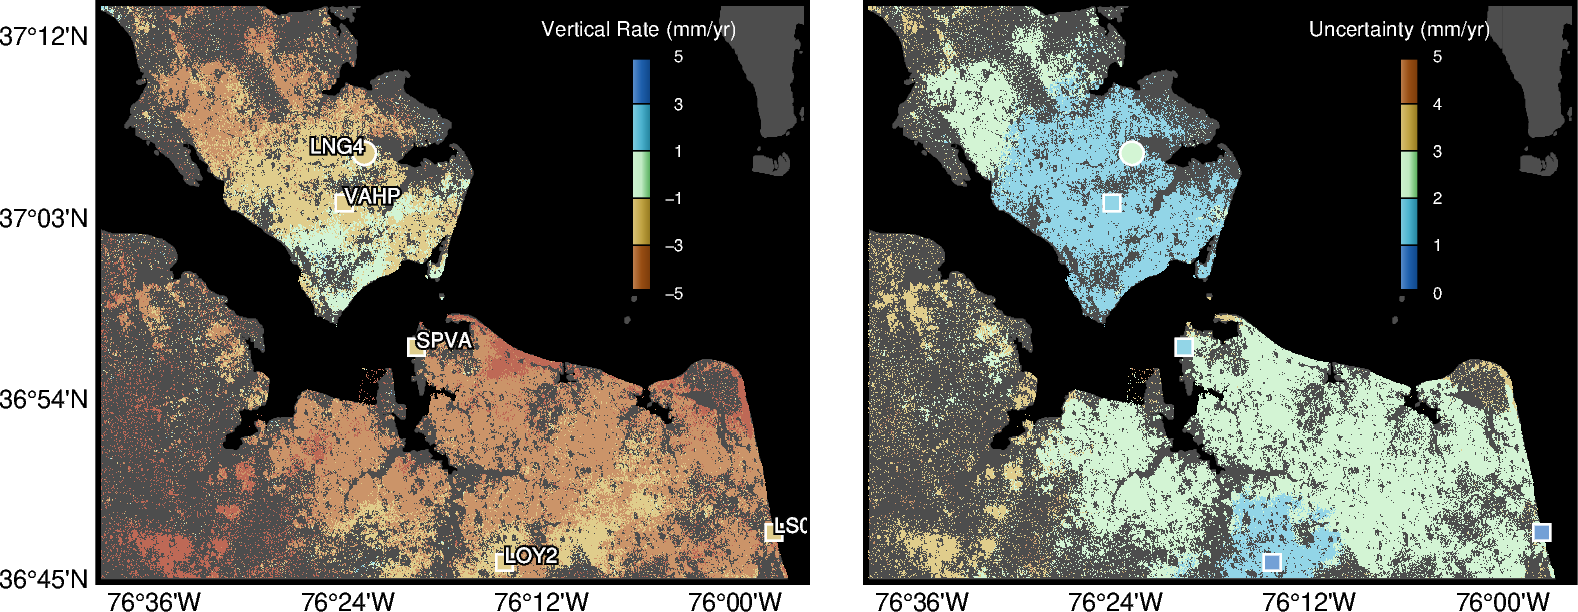

In [12]:
# Published
HR_Plot = PlotHR(Exp.path_mp_vup)

fig = HR_Plot.plot_together_gps(path_rate_orig, path_unc_orig, df_gps, continuous=False)
fig.show(dpi=600, width=1000)

grdimage [ERROR]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [ERROR]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage (gmtlib_read_grd_info): Use grdedit -A on your grid file to make region and increments compatible [/u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/Vup_MintPy/Vup/geo_rate_masked.nc]
grdimage [ERROR]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [ERROR]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage (gmtlib_read_grd_info): Use grdedit -A on your grid file to make region and increments compatible [/u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/Vup_MintPy/Vup/geo_std_masked.nc]


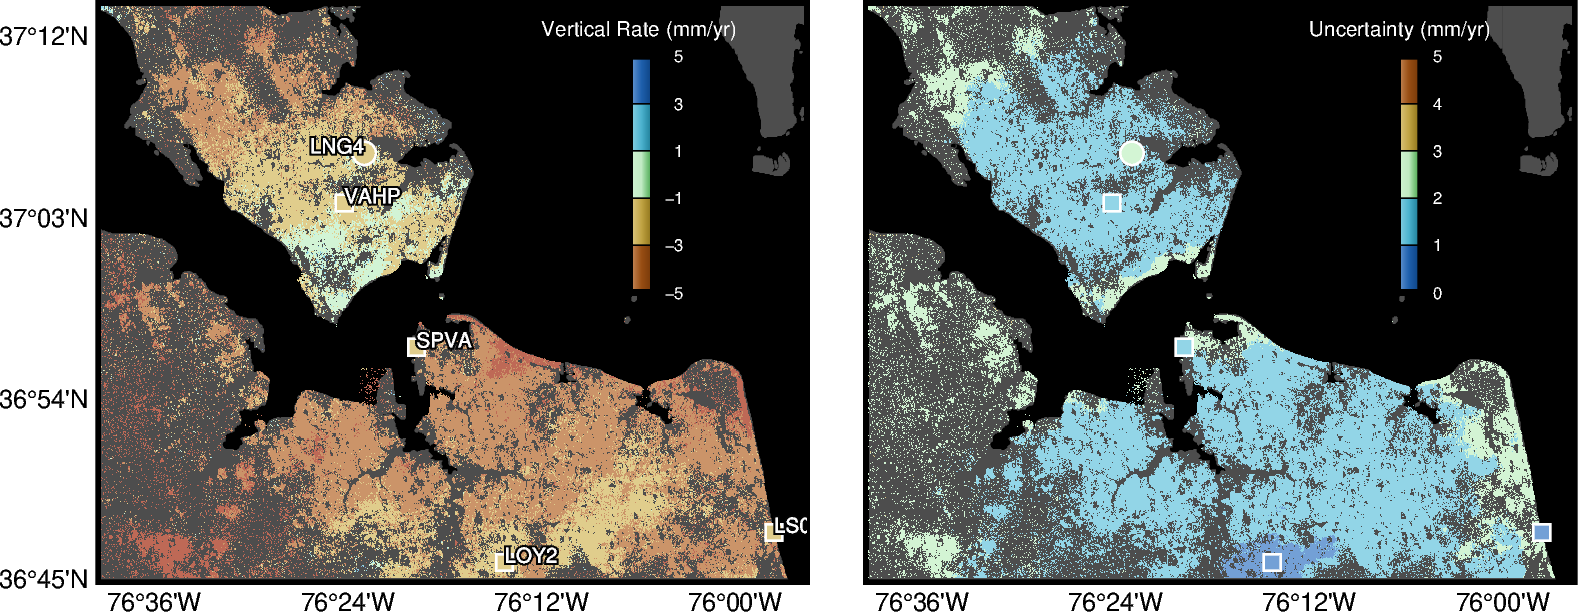

In [13]:
# Recreated ARIA
fig = HR_Plot.plot_together_gps(path_rate_orig1_mask, path_unc_orig1_mask, df_gps, continuous=False)
fig.show(dpi=600, width=1000)

grdinfo [ERROR]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdinfo [ERROR]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdinfo (gmtlib_read_grd_info): Use grdedit -A on your grid file to make region and increments compatible [/u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR2/MintPy_7alks_19rlks_33_15/geo_waterMask.nc]


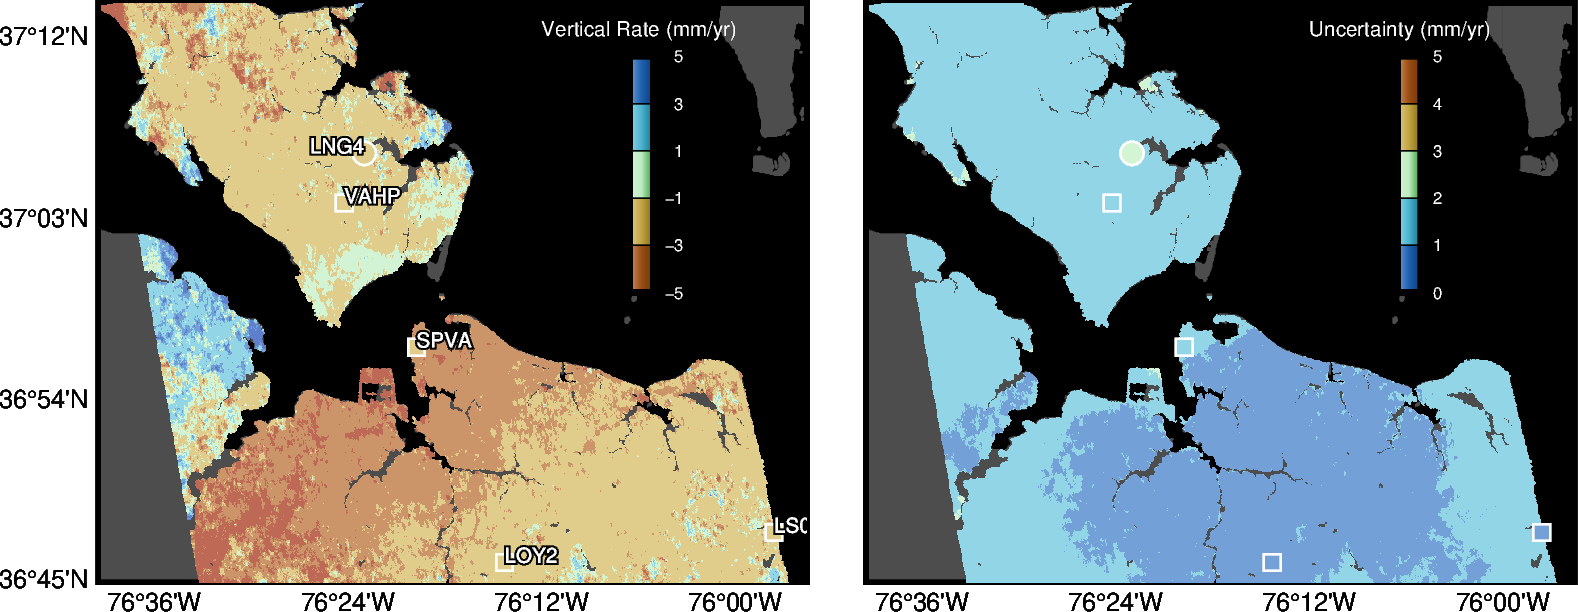

In [14]:
# FRINGE 
fig = HR_Plot.plot_together_gps(rate, unc, df_gps, mask, continuous=False)
fig.show(dpi=600, width=1000)

## Timeseries

In [47]:
# setup (all lat/lon, y/x)
VAHP     = '37.062178 -76.403436' # (1339, 857; 864, 1099)
LOY2     = '36.764016798 -76.237800713' # ( 554?, 501)


# lat/lon, yx (in fringe geo_timeseries ), yx (in HR2020), sta to ref to (tsview will make ref point == 0)
# must use LOY2 or switch how the stitching is done if you want to have them agree with mintpy
dct_locs = {
    'Central Hampton': [[37.0396, -76.4079], [1462, 842], [223, 297], 'VAHP'],
    'Norfolk Shipyard': [[36.8146, -76.3046], [454, 1305], [493, 421], 'LOY2'],
    #  'Craney Island': [[36.9188, -76.3754], [], [368, 336], 'SPVA'],
    'Craney Island': [[36.9237, -76.3671], [2095, 921], [362, 346], 'LOY2'],
    #  'First Landing': [[36.9121, -76.0196], [], [376,763], 'SPVA'],
    'First Landing': [[36.9270, -76.0200], [2077, 2165], [358, 763], 'LOY2'],
    
    'Test': [[36.9270, -76.0200], [742, 1516], [358, 763], 'LOY2'],

}

In [48]:
place    = 'Central Hampton'
loc      = dct_locs[place]
loc_lalo = loc[0]
gps_sta  = df_gps[df_gps.sta==loc[3]]
gps_loc  = f'{gps_sta.lat.item()} {gps_sta.lon.item()}'
gps_vup  = gps_sta.u_vel.item()

### FRInGE

tsview.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR2/MintPy_2alks_5rlks_33_15/geo_timeseries_demErr_SR.h5 --lalo 37.0396 -76.4079 --ref-lalo 37.062178105 -76.40343626999999 -u mm -c roma -v -20 20 --ylim -40 40 --no-multilook --ms 4
open timeseries file: geo_timeseries_demErr_SR.h5
No lookup table info range/lat found in files.
data   coverage in y/x: (0, 0, 2479, 3495)
subset coverage in y/x: (0, 0, 2479, 3495)
data   coverage in lat/lon: (-76.65497753137032, 37.30743028377248, -75.9281409133434, 36.66736176538629)
subset coverage in lat/lon: (-76.65497753137032, 37.30743028377248, -75.9281409133434, 36.66736176538629)
------------------------------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}
reading timeseries from file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR2/MintPy_2alks_5rlks_33_15/geo_timeseries_demErr_SR.

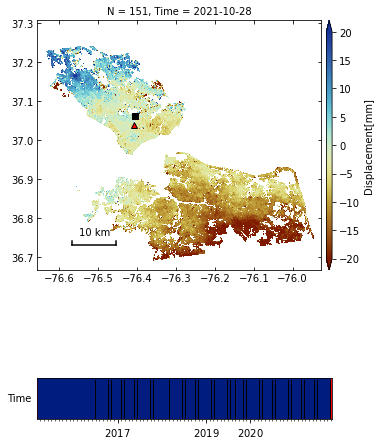

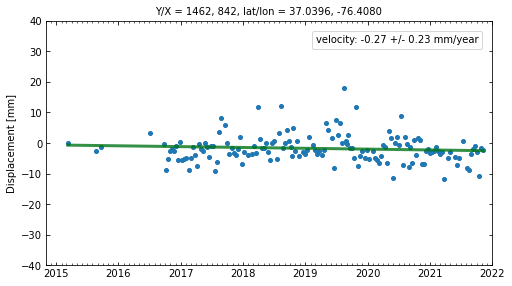

In [55]:
cmd  = f'tsview.py {Exp.path_ts_dem_geo} --lalo {loc_lalo[0]} {loc_lalo[1]} --ref-lalo {gps_loc} ' 
cmd += '-u mm -c roma -v -20 20 --ylim -40 40 --no-multilook --ms 4'

obj = timeseriesViewer(cmd); obj.configure(); obj.plot();

In [69]:
## Check the FRInGE conversion
# be careful because the underlying data is flipped (for selecting by pixels )
# np.flipud(rate_Fr)[loc_[1][0], loc[1][1]]
lst_dat      = [rate, unc] # not using masked
vup_rate_unc = [dat.sel(lat=loc_lalo[0], lon=loc_lalo[1], method='nearest').item() for dat in lst_dat]

inc_loc = bbMP.read_inc_MP(Exp.path_mp, xy=[loc[1][1],loc[1][0]])
sta     = gps_sta.sta.item()

if sta == 'VAHP':
    u_sta = sta
    u_vel = gps_vup
    u_sig = gps_sta.u_sig.item() 
else:
    u_sta = 'Offset'
    u_vel = offset[0]
    u_sig = offset[1]
    
print (f'{u_sta}: {u_vel:.2f} +/- {u_sig:.2f} mm/yr\n')
print (f'Vup: {vup_rate_unc[0]:.3f} +/- {vup_rate_unc[1]:.3f}')
print (f'LOS: {inc_loc*(vup_rate_unc[0]-u_vel):.2f} +/- {inc_loc*np.sqrt(vup_rate_unc[1]**2-u_sig**2):.2f}')

# LOS should match tsview above

/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing meth

VAHP: -1.23 +/- 1.00 mm/yr

Vup: -1.594 +/- 1.052
LOS: -0.27 +/- 0.23


### HR 2020n

tsview.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/VAHP_MintPy/timeseries.h5 --lalo 37.0396 -76.4079 --ref-lalo 37.062178105 -76.40343626999999 -u mm -c roma -v -20 20 --ylim -40 40 --no-multilook --ms 4
open timeseries file: timeseries.h5
No lookup table info range/lat found in files.
data   coverage in y/x: (0, 0, 874, 571)
subset coverage in y/x: (0, 0, 874, 571)
data   coverage in lat/lon: (-76.655833333, 37.225833333, -75.927500291, 36.75000019)
subset coverage in lat/lon: (-76.655833333, 37.225833333, -75.927500291, 36.75000019)
------------------------------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}
reading timeseries from file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/VAHP_MintPy/timeseries.h5
reference to date: 20150310
read mask from file: mask

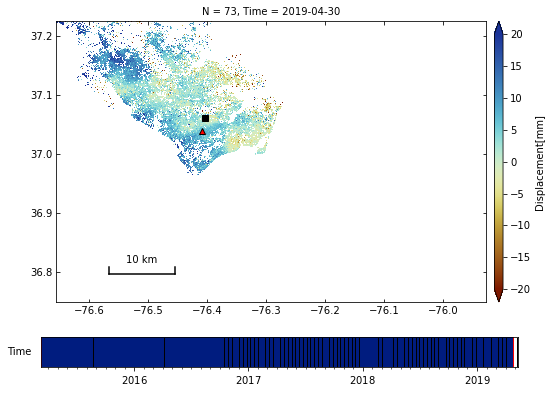

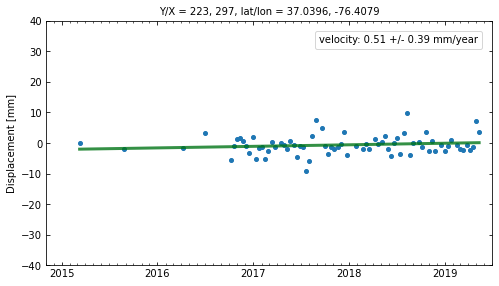

In [51]:
# these are original timeseries2velocity results... I think
path_ts0 = op.join(path_root_orig, f'{loc[3]}_MintPy', 'timeseries.h5')

cmd  = f'tsview.py {path_ts0} --lalo {loc_lalo[0]} {loc_lalo[1]} --ref-lalo {gps_loc} ' # --offset {gps_vup}
cmd += '-u mm -c roma -v -20 20 --ylim -40 40 --no-multilook --ms 4'# --noverbose'

obj = timeseriesViewer(cmd); obj.configure(); obj.plot();

In [65]:
## Check the HR2020 conversion
# be careful because the underlying data is flipped (for selecting by pixels )
# np.flipud(rate_Fr)[loc_[1][0], loc[1][1]]
print (place)

# use the new ones (made from the original timeseries) to match exactly (since no bootstrapping)
lst_dat      = [rate_2020n, unc_2020n] # not using masked
vup_rate_unc = [dat.sel(lat=loc_lalo[0], lon=loc_lalo[1], method='nearest').item() for dat in lst_dat]

inc_loc = bbMP.read_inc_MP(path_vup_mp_orig, xy=[loc[2][1],loc[2][0]])

# since using simple stitch, dont need offset
sta     = gps_sta.sta.item()

u_sta = sta
u_vel = gps_vup
u_sig = gps_sta.u_sig.item() 

print (f'{u_sta}: {u_vel:.2f} +/- {u_sig:.2f} mm/yr\n')
print (f'Vup: {vup_rate_unc[0]:.3f} +/- {vup_rate_unc[1]:.3f}') # close to paper
print (f'LOS: {inc_loc*(vup_rate_unc[0]-u_vel):.2f} +/- {inc_loc*np.sqrt(vup_rate_unc[1]**2-u_sig**2):.2f}')

# LOS should match tsview above

Central Hampton
VAHP: -1.23 +/- 1.00 mm/yr

Vup: -0.547 +/- 1.132
LOS: 0.51 +/- 0.39


/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing meth

### HR2020 0

In [74]:
## copy the data from my stitched h5 into mintpy format
path_ts1 = op.join(path_vup_mp_orig, 'timeseries.h5')
!cp {path_ts0} {path_ts1}
src      = path_stitch_orig

with h5py.File(src, 'r') as h5:
    ts_raw  = h5['raw'][:]/1000
    ts_disp = h5['disp'][:]/1000
    dates   = h5['dates'][:]
    rates   = h5['rate'][:]
    unc     = h5['rate_bootstrap'][:]
    
with h5py.File(path_ts1, 'r+') as h5:
    data = h5['timeseries']
    data[:] = ts_raw
    
    data.attrs['FILE_PATH'] = path_ts1

dates = [i.decode() for i in dates] # gets rid of the leading b
dt    = bbTS.date2dec(pd.to_datetime(dates))

# ## create the timeseries from it
# path_v_los = op.join(path_vup_mp_orig, 'stitched_vel_LOY2.h5')
# timeseries2velocity path_ts1} path_vel_new

In [75]:
y, x = dct_locs['Norfolk Shipyard'][2]
# y, x, = 554, 501 # LOY2

ts_raw1   = ts_raw[:, y, x]*1000
rate_raw1 = np.polyfit(dt, ts_raw1, 1)[0]
ts_disp1   = ts_disp[:, y, x]*1000
rate_disp1 = np.polyfit(dt, ts_disp1, 1)[0]


print (f'Calculated rates, Raw: {rate_raw1:.2f}, Disp: {rate_disp1:.2f} mm/yr')
print (f'From object: {rates[y,x]:.2f} +/- {unc[y,x]:.2f} mm/yr') # (this is VAHP where LOY2 should be)


# plt.plot(dates, ts_raw1, c='k')
# plt.plot(dates, ts_disp1, c='r')
# plt.plot(ts_disp1-ts_raw1)
# print (ts_disp1-ts_raw1)

## this is, correctly, the down shifted (to LOY2) rate
print (f'Published: {np.flipud(rate_2020)[y, x].item():.2f} +/- {np.flipud(unc_2020)[y, x].item():.2f} mm/yr')



Calculated rates, Raw: -0.35, Disp: -1.40 mm/yr
From object: -2.63 +/- 2.27 mm/yr
Published: -3.08 +/- 2.38 mm/yr


tsview.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/Vup_MintPy/timeseries.h5 --lalo 37.0396 -76.4079 --ref-lalo 37.062178105 -76.40343626999999 -u mm -c roma -v -20 20 --ylim -40 40 --no-multilook --ms 4
open timeseries file: timeseries.h5
No lookup table info range/lat found in files.
data   coverage in y/x: (0, 0, 874, 571)
subset coverage in y/x: (0, 0, 874, 571)
data   coverage in lat/lon: (-76.655833333, 37.225833333, -75.927500291, 36.75000019)
subset coverage in lat/lon: (-76.655833333, 37.225833333, -75.927500291, 36.75000019)
------------------------------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}
reading timeseries from file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/Vup_MintPy/timeseries.h5
reference to date: 20150310
data    range: [-159.5346, 

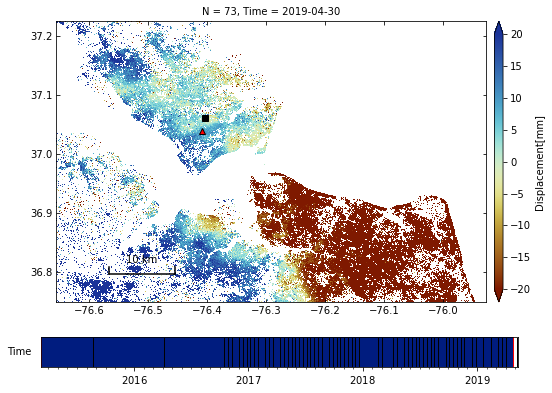

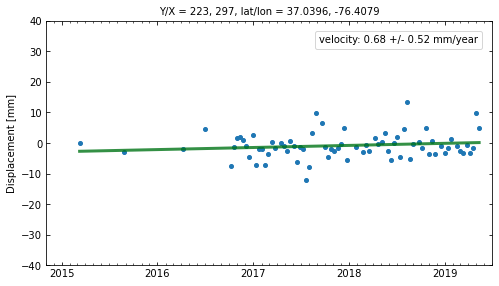

In [76]:
# lets see if the timeseries in raw, stitched match those in the velocitys
cmd  = f'tsview.py {path_ts1} --lalo {loc_lalo[0]} {loc_lalo[1]} --ref-lalo {gps_loc} ' # --offset {gps_vup}
cmd += '-u mm -c roma -v -20 20 --ylim -40 40 --no-multilook --ms 4'# --noverbose'

obj = timeseriesViewer(cmd); obj.configure(); obj.plot();

In [78]:
## Check the HR2020 conversion
# be careful because the underlying data is flipped (for selecting by pixels )
# np.flipud(rate_Fr)[loc_[1][0], loc[1][1]]

# use the new ones (made from the original timeseries) to match exactly (since no bootstrapping)
lst_dat      = [rate_2020n, unc_2020n] # not using masked
vup_rate_unc = [dat.sel(lat=loc_lalo[0], lon=loc_lalo[1], method='nearest').item() for dat in lst_dat]

inc_loc = bbMP.read_inc_MP(path_vup_mp_orig, xy=[loc[2][1],loc[2][0]])

# since using simple stitch, dont need offset
sta     = gps_sta.sta.item()

u_sta = sta
u_vel = gps_vup
u_sig = gps_sta.u_sig.item() 

print (f'{u_sta}: {u_vel:.2f} +/- {u_sig:.2f} mm/yr\n')
print (f'Vup: {vup_rate_unc[0]:.3f} +/- {vup_rate_unc[1]:.3f}')
print (f'LOS: {inc_loc*(vup_rate_unc[0]-u_vel):.2f} +/- {inc_loc*np.sqrt(vup_rate_unc[1]**2-u_sig**2):.2f}')

# LOS should match tsview above

VAHP: -1.23 +/- 1.00 mm/yr

Vup: -0.547 +/- 1.132
LOS: 0.51 +/- 0.39


/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing meth

### Compare the standard deviation of all the time series

view.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR2/MintPy_2alks_5rlks_33_15/geo_TSig_SR.h5 tsStd -u mm -v 0 30 --figsize 10 10 -c afmhot_r --noverbose --noref


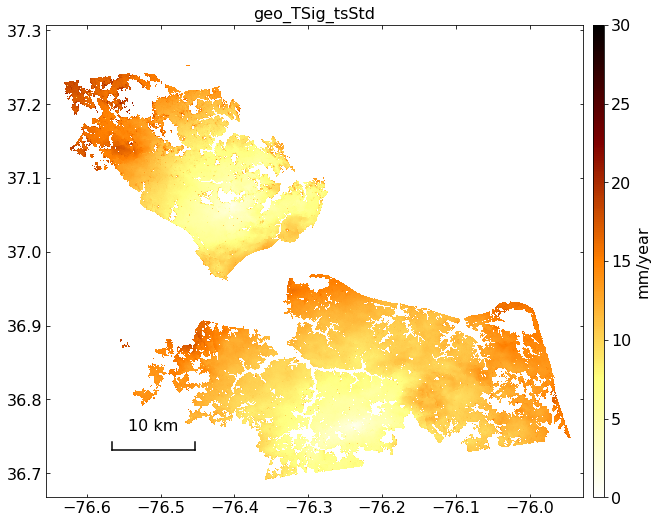

view.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/track_004/Results/IGS14_GRL2020/Vup_MintPy/geo_velocity_std.h5 velocityStd -u mm -v 0 30 --figsize 10 10 -c afmhot_r --noverbose --noref


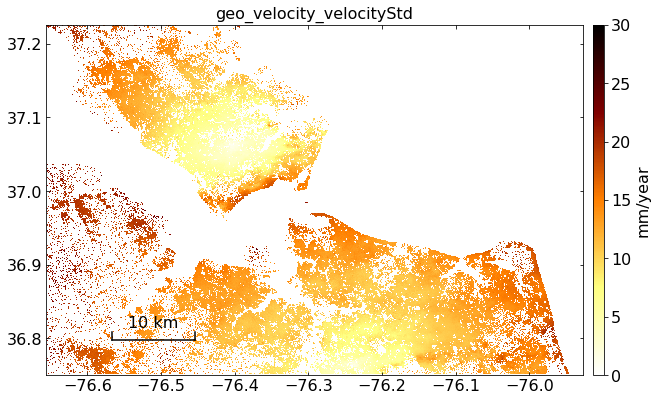

In [87]:
%matplotlib inline
path_2020_std = op.join(path_root_orig, 'Vup_MintPy', 'geo_velocity_std.h5')

for i, path in enumerate([Exp.path_tsig_geo, path_2020_std]):
    ds  = 'tsStd' if i == 0 else 'velocityStd'
    cmd = f'view.py {path} {ds} -u mm -v 0 30 --figsize 10 10 -c afmhot_r --noverbose --noref ' 
#     if i == 0:
#         cmd += f'-m {path_mask_vup}'
    obj = viewer(cmd); obj.configure(); obj.plot()